## Import

In [1]:
import numpy as np
import pandas as pd

import os
import sys

import matplotlib.pyplot as plt
# %matplotlib inline

import cv2

# from classifiers import R_from_path

In [107]:
from utils import append_generic, find_closest_point
from preprocessing import draw_contours_yao, get_contours
from dataloader import split_dual_xray_image

In [3]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

sys.path.append(os.path.join(code_path, 'project_x_ray_images_stack'))
# sys.path.append(r'E:\photoelectric_sorting\codes\project_x_ray_images_stack')

In [94]:
import logging
from tools.analyzer_two_thresh import BaselineOreGrading

In [134]:
import importlib
from tools import analyzer_two_thresh
importlib.reload(analyzer_two_thresh)

import utils
importlib.reload(utils)

<module 'utils' from '/Users/zhengyun/Desktop/yaojian/codes/jt_ore_sorting/utils.py'>

In [4]:
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score

In [5]:
from matplotlib import rc

rc('text', usetex=False)
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal',
        'size': 10}
rc('font', **font)

In [6]:
from pathlib import Path

In [151]:
import seaborn as sns

# sns.set_context("notebook")
# sns.set_context('talk')
# sns.set_style("ticks")
# sns.set_style("whitegrid")

sns.reset_defaults()


In [8]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:



path_excel = os.path.join(data_path, '化验结果/20250219化验结果.xlsx')

df = pd.read_excel(path_excel, nrows=110, usecols=range(6))
print(df.head(1))

#把含有空值的某一行，除了第一列都设成0 
df.loc[df.isna().any(axis = 1), df.columns[1:]] = 0
true_0219 = df.iloc[:, 0:6].to_numpy()

zn_0219 = true_0219[:, 2]
pb_0219 = true_0219[:, 3]
fe_0219 = true_0219[:, 1]
zn_pb_0219 = true_0219[:, 2] + true_0219[:, 3]
zn_pb_fe_0219 = true_0219[:, 2] + true_0219[:, 3] + true_0219[:, 1]
weight = true_0219[:, 5]

   Sample No.      Fe     Zn     Pb      S  Weight(g)
0            1  30.13  0.031  0.063  34.83       39.9


In [88]:
df.rename(columns={
    'Fe': "Fe_grade",
    'Zn': "Zn_grade",
    'Pb': "Pb_grade",
    'S': "S_grade",
    'Weight(g)': "weight"
}, inplace=True)

In [100]:
df.iloc[0:99, :]

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight
0,1,30.130,0.031,0.063,34.83,39.9
1,2,7.446,0.784,2.125,6.72,50.4
2,3,30.480,0.058,0.045,31.65,69.8
3,4,31.200,0.089,0.319,31.76,48.8
4,5,9.662,10.170,1.353,11.81,48.7
...,...,...,...,...,...,...
94,95,17.210,7.610,14.610,21.36,78.8
95,96,8.224,7.918,1.075,9.27,41.2
96,97,6.810,18.470,3.170,13.60,21.8
97,98,12.790,18.120,3.522,19.12,94.6


## definitions

In [171]:
def prepare_R(path, roi, max_len = 6, length = 100, s_i = 0, direction = 'ublr', th_val = 105,
                save_rock_image = False):
    '''
    return low, high, rock_pixels, low_contoured, contours
    '''
        
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    # cv2.IMREAD_GRAYSCALE 或 0， 转换为0-255的灰度图
    # cv2.IMREAD_COLOR 或 1，转换为3通道的彩色图
    # cv2.IMREAD_UNCHANGED 或 -1， 保持原来的不变

    low, high = split_dual_xray_image(image.T) #为了与函数输入一致，先将图像transpose

    low, high = low.T, high.T # 先转置回来

    y1, y2, x1, x2 = roi

    low, high = cv2.flip(low[y1:y2, x1:x2], 0), cv2.flip(high[y1:y2, x1:x2], 0) 
    # 先选择感兴趣区域
    # X射线探测器成像与实际矿石摆放位置（俯视）差180°且左右相反
    # 等效为沿着垂直方向翻转

    low_contoured, rock_pixels, contours = get_contours(low, high, th_val = th_val, max_len = max_len, length=length, 
                                              direction = direction, path = path, s_i = s_i, save_rock_image=save_rock_image)

    return low, high, rock_pixels, low_contoured, contours


def R_from_path(low, high, rock_pixels, I0_low, I0_high, input = 'images', method = 'a', const = [5, 20]):
    '''return (R_pixels) R_images, low, high, rock_pixels'''
         
    R_images = compute_R(low, high, I0_low, I0_high, input = 'images', method= method, const=const)
    
    if input == 'pixels':
        R_pixels = compute_R(rock_pixels[0], rock_pixels[1], I0_low, I0_high, input = input, method= method, const=const)
        return R_pixels, R_images    
    else:
        return R_images

def compute_R(low, high, I0_low, I0_high, input = 'images', method = 'a', const = [5, 20]):

    '''
    input: 'images' or 'pixels', whole images of low and high energy or pixels of rocks
    
    '''

    if input == 'images':
        if method == 'a':
            return np.log(I0_low/(low+1e-6) + const[0] )/np.log(I0_high/(high+1e-6) + const[1])

        elif method == 'b':
            return np.log((low + 1e-6))/(np.log(high+1e-6 + 200.0))
         
    elif input == 'pixels':
        R_values = []
        for i in range(len(low)):

            if method == 'a':
                R_i =np.log(I0_low/(low[i]+1e-6) + const[0] )/np.log(I0_high/(high[i]+1e-6) + const[1])

            elif method == 'b':
                R_i = np.log((low[i] + 1e-6))/(np.log(high[i]+1e-6 + 200.0))   
            R_values.append(R_i)

        return R_values     


In [118]:
def calculate_rates(predictions, true_results, count_Fe = False):
    '''
    计算抛废率、回收率、铅锌富集比、铅锌平均品位
    :param predictions: 预测结果，一维数组
    :param true_results: 真实结果，excel表格
    
    :return: 抛废率、回收率、铅锌富集比、铅锌平均品位
    '''
    high_grade_mask = predictions == 1
    low_grade_mask = predictions == 0

    Fe_grade = true_results[:, 1]
    zn_grade = true_results[:, 2]
    pb_grade = true_results[:, 3]
    zn_pb_grade = zn_grade + pb_grade

    if count_Fe:
        zn_pb_grade = zn_grade + pb_grade + Fe_grade

    weight = true_results[:, 5]

    miss = (zn_grade == 0).sum()
    correction = len(predictions)/(len(predictions) - miss)

    # 计算抛废率和回收率
    scrap_rate = weight[low_grade_mask].sum() / weight.sum()
    recovery_rate = (weight[high_grade_mask] * zn_pb_grade[high_grade_mask]).sum() / (weight * zn_pb_grade).sum()

    # 计算富集率
    avg_pb_grade_all = pb_grade.mean()*correction
    avg_zn_grade_all = zn_grade.mean()*correction

    avg_pb_grade_high = (pb_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_zn_grade_high = (zn_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_pb_grade_low = (pb_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()
    avg_zn_grade_low = (zn_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()

    # avg_pb_grade_high = pb_grade[high_grade_mask].mean()*correction
    # avg_zn_grade_high = zn_grade[high_grade_mask].mean()*correction
    # avg_pb_grade_low =  pb_grade[low_grade_mask].mean()*correction
    # avg_zn_grade_low = zn_grade[low_grade_mask].mean()*correction

    enrichment_Pb = avg_pb_grade_high / avg_pb_grade_all if avg_pb_grade_all != 0 else 0
    enrichment_Zn = avg_zn_grade_high / avg_zn_grade_all if avg_zn_grade_all != 0 else 0

    return {
        '抛废率': '%.3f'%scrap_rate,
        '回收率': '%.3f'%recovery_rate,
        '铅富集比': '%.3f'%enrichment_Pb,
        '锌富集比': '%.3f'%enrichment_Zn,
        '铅平均品位（保留）': '%.3f'%avg_pb_grade_high,
        '锌平均品位（保留）': '%.3f'%avg_zn_grade_high,
        '铅平均品位（抛废）': '%.3f'%avg_pb_grade_low,
        '锌平均品位（抛废）': '%.3f'%avg_zn_grade_low,
        '铅平均品位': '%.3f'%avg_pb_grade_all,
        '锌平均品位': '%.3f'%avg_zn_grade_all,
    }

def get_and_plot_rates(R_mean, rrange, true, condition, count_Fe = False, accuracy_weight = None, title = '', plot = False):
    '''
    计算并画出抛废率和回收率随R阈值变化的曲线
    :param R_mean: R值的均值
    :param range: R阈值的范围
    :param true: 真实的化验数据
    :param condition: 认为是精矿的条件
    '''

    final = [[], [], [], []]

    for r in rrange:
        pre = R_mean >  r
        res = calculate_rates(pre, true, count_Fe=count_Fe)
        score = accuracy_score(condition, pre, sample_weight=accuracy_weight)
        # print('%.3f'%r, '%.3f'%score, res)

        final[0].append(r)
        final[1].append(score*100)
        final[2].append(float(res['抛废率'])*100)
        final[3].append(float(res['回收率'])*100)

    if plot:

        # plt.axhline(y=95, color='k', linestyle='--', alpha = 0.5, label = '95%')

        # plt.axvline(x=0.72, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.72$')
        # plt.axvline(x=0.70, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.70$')

        # plt.text(x = 0.73, y = 92, s = 'R = 0.72, scrap%=35%, \n recovery%=94%', fontsize = 15)
        plt.plot(final[0], final[1], label = 'classification score')
        plt.plot(final[0], final[2], label = 'scrap rate')
        plt.plot(final[0], final[3], label = 'recovery rate')
        
        plt.legend(fontsize = 15, frameon = False)
        plt.xlabel('R threshold')
        plt.ylabel('Rates (%)')
        plt.title(title)
        plt.show()

    return final

## analysis

In [49]:
len(pre_0219_2[-1] + pre_0219_1[-1])

105

In [78]:
I0_low, I0_high = 195, 196
# path_0219 = "E:/photoelectric_sorting/data/20250219/160kV_4mA_forward.png"
# path_0217 = "E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_4mA.png" #[110, 1000, 400, 1200]

path_0219 = os.path.join(data_path, '20250219/160kV_4mA_forward.png')

#low_0219, high_0219, rock_pixels_19, low_contoured_19, contours 
pre_0219_2 = prepare_R(path_0219, [105, 1000, 400, 1200], max_len = 6, length=102, th_val = 105,
                                  direction = 'ublr', s_i = 64, save_rock_image=False)

pre_0219_1 = prepare_R(path_0219, [1950, -100, 350, 1150], max_len = 9, length=35, th_val = 105,
                                  direction = 'ublr', s_i = 1, save_rock_image=False)

pre_0219 =[append_generic(pre_0219_1[i], pre_0219_2[i]) for i in range(len(pre_0219_1))]

# #R_0219_pixels, R_0219_image
# results_0219_second = R_from_path(*pre_0219_2[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)


# results_0219_first = R_from_path(*pre_0219_1[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)

# results_0219 =[append_generic(results_0219_first[i], results_0219_second[i]) for i in range(5)]

consts = [5, 20]
results_0219 = R_from_path(*pre_0219[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)   
R_0219_mean = np.array([results_0219[0][i].mean() for i in range(len(results_0219[0]))])

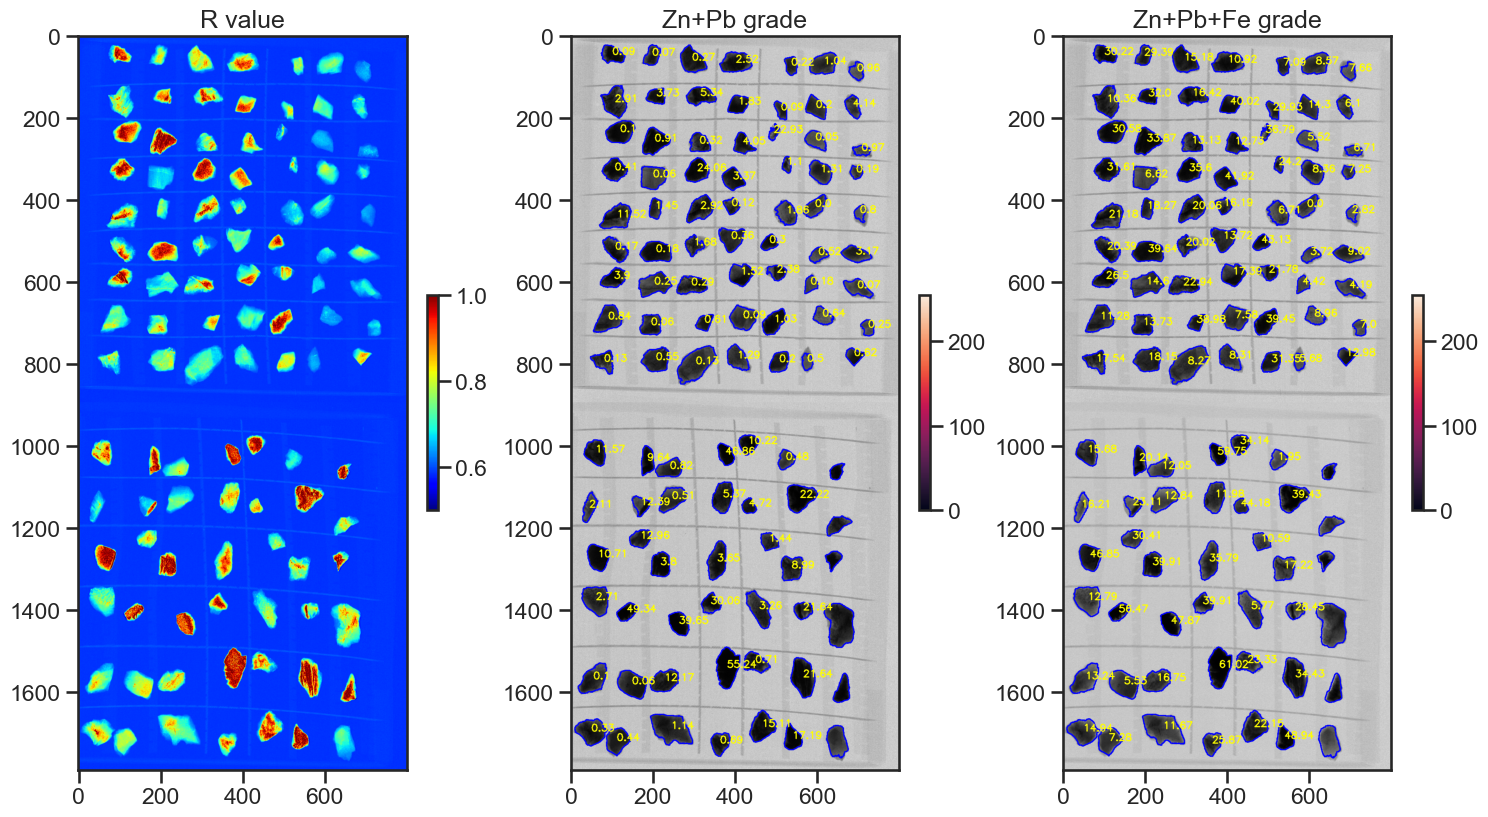

In [46]:
grade_image1, _ = draw_contours_yao(pre_0219_1[0], pre_0219_1[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_0219[0:63])
grade_image2, _ = draw_contours_yao(pre_0219_2[0], pre_0219_2[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_0219[63:99])

grade_image = np.concatenate((grade_image1, grade_image2))

grade_image1_fe, _ = draw_contours_yao(pre_0219_1[0], pre_0219_1[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_fe_0219[0:63])
grade_image2_fe, _ = draw_contours_yao(pre_0219_2[1], pre_0219_2[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_fe_0219[63:99])

grade_image_fe = np.concatenate((grade_image1_fe, grade_image2_fe))

fig, axes = plt.subplots(1,3, figsize=(18,14))
im = axes[0].imshow(results_0219[1][:, :], vmin = 0.5, vmax = 1, cmap = 'jet')
axes[0].set_title('R value')
fig.colorbar(im, ax=axes[0], shrink=0.2)
# im6 = axes[1].imshow(results_0219[4][:, :])
im6 = axes[1].imshow(grade_image)
fig.colorbar(im6, ax = axes[1], shrink=0.2)
axes[1].set_title('Zn+Pb grade')
im7 = axes[2].imshow(grade_image_fe)
fig.colorbar(im7, ax = axes[2], shrink=0.2)
axes[2].set_title('Zn+Pb+Fe grade')
plt.show()

In [37]:
import numpy as np
from scipy.stats import pearsonr

# 假设 zn_pb_0219, R_0219_mean, zn_pb_fe_0219 已经定义
# 计算 zn_pb_0219 和 R_0219_mean 的皮尔逊相关系数和 p 值
corr_1, p_value_1 = pearsonr(zn_pb_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_0219 和 R_0219_mean 的皮尔逊相关系数: {corr_1:.2f}, p 值: {p_value_1:.2e}")

# 计算 zn_pb_fe_0219 和 R_0219_mean 的皮尔逊相关系数和 p 值
corr_2, p_value_2 = pearsonr(zn_pb_fe_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_fe_0219 和 R_0219_mean 的皮尔逊相关系数: {corr_2:.2f}, p 值: {p_value_2:.2e}")

from scipy.stats import spearmanr

# 计算 zn_pb_0219 和 R_0219_mean 的斯皮尔曼等级相关系数和 p 值
corr_3, p_value_3 = spearmanr(zn_pb_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_0219 和 R_0219_mean 的斯皮尔曼等级相关系数: {corr_3:.2f}, p 值: {p_value_3:.2e}")

# 计算 zn_pb_fe_0219 和 R_0219_mean 的斯皮尔曼等级相关系数和 p 值
corr_4, p_value_4 = spearmanr(zn_pb_fe_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_fe_0219 和 R_0219_mean 的斯皮尔曼等级相关系数: {corr_4:.2f}, p 值: {p_value_4:.2e}")

from scipy.stats import kendalltau

# 计算 zn_pb_0219 和 R_0219_mean 的肯德尔等级相关系数和 p 值
corr_5, p_value_5 = kendalltau(zn_pb_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_0219 和 R_0219_mean 的肯德尔等级相关系数: {corr_5:.2f}, p 值: {p_value_5:.2e}")

# 计算 zn_pb_fe_0219 和 R_0219_mean 的肯德尔等级相关系数和 p 值
corr_6, p_value_6 = kendalltau(zn_pb_fe_0219, R_0219_mean)
# 修改输出格式，相关系数保留两位小数，p值以科学计数法保留两位有效数字
print(f"zn_pb_fe_0219 和 R_0219_mean 的肯德尔等级相关系数: {corr_6:.2f}, p 值: {p_value_6:.2e}")

zn_pb_0219 和 R_0219_mean 的皮尔逊相关系数: 0.53, p 值: 7.38e-09
zn_pb_fe_0219 和 R_0219_mean 的皮尔逊相关系数: 0.72, p 值: 3.77e-18
zn_pb_0219 和 R_0219_mean 的斯皮尔曼等级相关系数: 0.39, p 值: 5.00e-05
zn_pb_fe_0219 和 R_0219_mean 的斯皮尔曼等级相关系数: 0.68, p 值: 2.26e-15
zn_pb_0219 和 R_0219_mean 的肯德尔等级相关系数: 0.27, p 值: 4.52e-05
zn_pb_fe_0219 和 R_0219_mean 的肯德尔等级相关系数: 0.52, p 值: 3.77e-15


/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_44263/2976917686.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


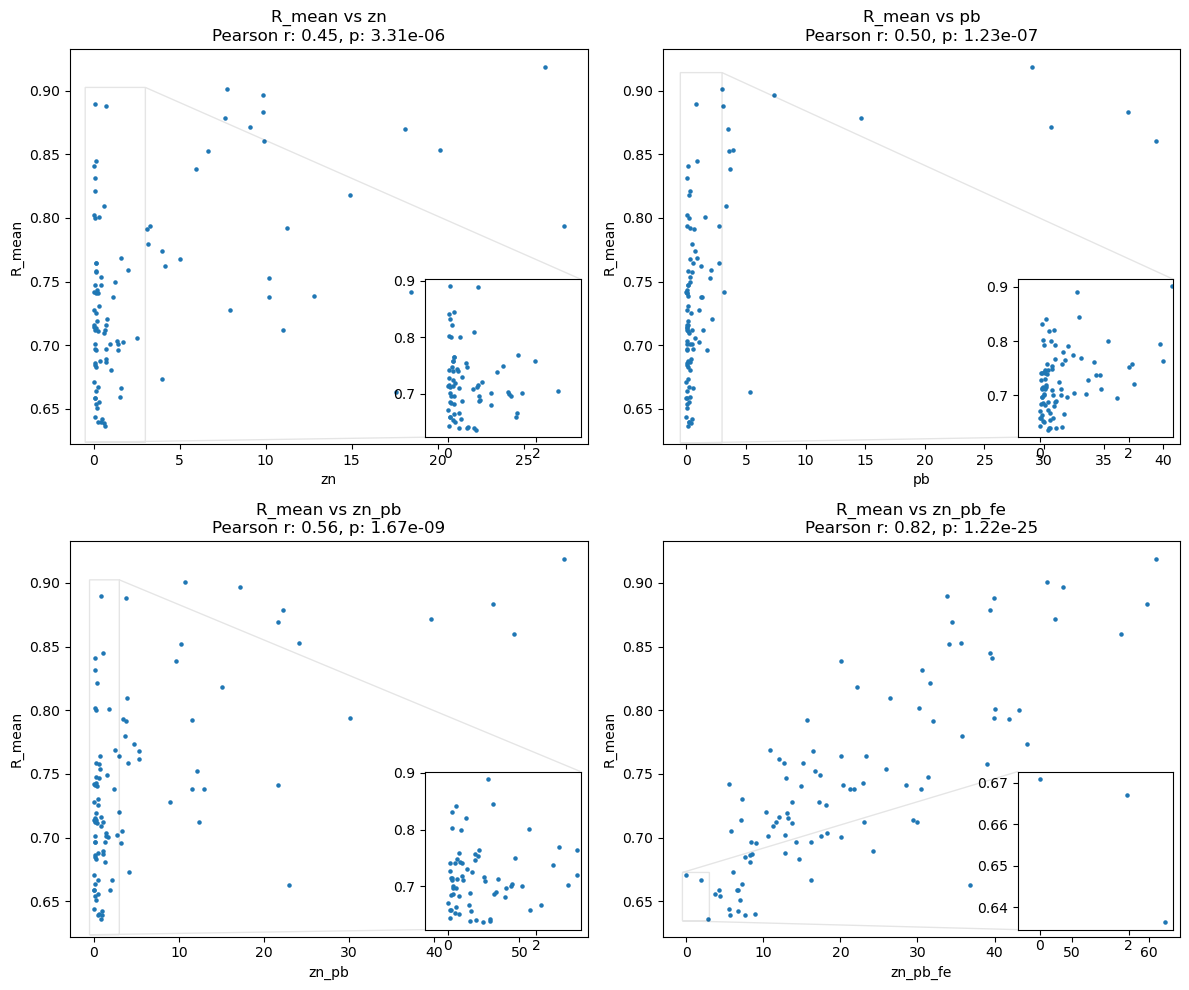

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 创建一个包含 2x2 子图的 Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

data_pairs = [(zn_0219[0:99], R_0219_mean[0:99]), (pb_0219[0:99], R_0219_mean[0:99]), (zn_pb_0219[0:99], R_0219_mean[0:99]), (zn_pb_fe_0219[0:99], R_0219_mean[0:99])]
labels = ['zn', 'pb', 'zn_pb', 'zn_pb_fe']
marker_size = 5
for i, (ax, (x, y), label) in enumerate(zip(axes.flat, data_pairs, labels)):
    # 绘制主散点图
    ax.scatter(x, y, s=marker_size)
    corr, p = pearsonr(x, y)
    ax.set_title(f'R_mean vs {label}\nPearson r: {corr:.2f}, p: {p:.2e}')
    ax.set_xlabel(label)
    ax.set_ylabel('R_mean')

    # 创建嵌入的小图
    axins = inset_axes(ax, width="30%", height="40%", loc='lower right')

    # 筛选 x 坐标在 0 - 3 范围内的点
    mask = (x >= 0) & (x <= 3)
    x_zoom = x[mask]
    y_zoom = y[mask]

    # 绘制小图
    axins.scatter(x_zoom, y_zoom, s=marker_size)
    axins.set_xlim(-0.5, 3)

    # 标记小图与主图的对应区域
    ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.1)

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()

In [65]:
calculate_rates(zn_pb_0219[0:99] > 3, true_0219[0:99, :])

{'抛废率': '0.630', '回收率': '0.924'}

In [30]:
calculate_rates(zn_pb_fe_0219[0:99] > 10.0, true_0219[0:99, :])

{'抛废率': '0.212', '回收率': '0.969'}

## R_double_threshold()

In [122]:
len(results_0219[0])

105

In [ ]:
# 配置日志以显示 INFO 级别的消息
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')    


2025-03-21 14:59:26,461 - WARNING - 指定的中文字体未找到。使用默认字体。


In [150]:
# 初始化 BaselineOreGrading 模型
baseline_model = BaselineOreGrading(ann=df.iloc[0:99, :], pixels=pd.Series(results_0219[0][0:99]))

# 执行超参数调优
best_params, best_tuning_metrics = baseline_model.hyperparameter_tuning(
    min_recovery_rate=0.95,
    min_scrap_rate=0.2,
    A_range=np.arange(0.5, 1.2, 0.01),
    step_B=0.05
)
print(best_params)

2025-03-21 14:59:55,008 - WARNING - 指定的中文字体未找到。使用默认字体。
2025-03-21 14:59:55,010 - INFO - 开始进行超参数调优...


None


In [ ]:

if best_params:
    best_threshold_A, best_threshold_B = best_params
    print("\n=== 最佳超参数 ===")
    print(f"灰度阈值: {best_threshold_A}")
    print(f"比例阈值: {best_threshold_B * 100:.2f}%")

    # 使用最佳超参数进行矿石分类
    predictions = baseline_model.classify_ores(best_threshold_A, best_threshold_B)

    grade_threshold = 0.025
    # 使用最佳超参数计算基于品位的指标
    grade_based_metrics = baseline_model.calculate_grade_based_metrics(
        predictions=predictions,
        grade_threshold=grade_threshold
    )

    print("\n=== 调优指标 ===")
    for metric, value in best_tuning_metrics.items():
        print(f"{metric}: {value:.2%}")

    print(f"\n=== 基于品位阈值{grade_threshold*100:.2f}%的二分类指标 ===")
    for metric, value in grade_based_metrics.items():
        print(f"{metric}: {value:.2%}")
else:
    print("未找到符合指定约束条件的合适参数。")

# 计算曲线数据
try:
    scrap_rates_ideal, recovery_rates_ideal, grade_thresholds_ideal = baseline_model.compute_ideal_curve()
    scrap_rates_baseline, recovery_rates_baseline, grade_thresholds_baseline = baseline_model.compute_baseline_curve()
    pareto_front = baseline_model.pareto_front
except Exception as e:
    logging.error(f"计算曲线时出错: {e}")

# 计算 AUC 结果
auc_results = baseline_model.compute_auc(scrap_rates_ideal, recovery_rates_ideal)

# 显示 AUC 结果
print("\n=== AUC 结果 ===")
for key, value in auc_results.items():
    if not np.isnan(value):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: 未计算")

# 识别最佳点
best_sum_point = None
best_enrichment_point = None
best_constraint_point = None

if not pareto_front.empty:
    # 1. 最佳总和点（最大抛废率 + 回收率）
    pareto_front['score_sum'] = pareto_front['抛废率'] + pareto_front['回收率']
    best_sum_point = pareto_front.loc[pareto_front['score_sum'].idxmax()]

    # 2. 最佳富集点（最大铅和锌富集比之和）
    pareto_front['enrichment_sum'] = pareto_front['铅富集比'] + pareto_front['锌富集比']
    best_enrichment_point = pareto_front.loc[pareto_front['enrichment_sum'].idxmax()]

    # 3. 最佳约束点（如果存在）
    if baseline_model.best_under_constraints:
        best_constraint_point = pd.Series({
            'threshold_A': baseline_model.best_under_constraints[0],
            'threshold_B': baseline_model.best_under_constraints[1],
            '抛废率': baseline_model.best_under_constraints[2]['抛废率'],
            '回收率': baseline_model.best_under_constraints[2]['回收率'],
            '铅富集比': baseline_model.best_under_constraints[2]['铅富集比'],
            '锌富集比': baseline_model.best_under_constraints[2]['锌富集比'],
            '品位阈值': (baseline_model.best_under_constraints[2]['抛废率'] +
                            baseline_model.best_under_constraints[2]['回收率']) / 2
        })
else:
    logging.warning("没有可用的 Pareto 前沿来识别最佳点。")

# 找到最接近目标回收率的点
target_recovery = 0.95
closest_point = baseline_model.find_closest_point(target_recovery)

# 获取 closest_point 对应的 灰度阈值 和 比例阈值
if closest_point:
    print(f"\n=== 95%回收率指标 ===")
    scrap, recovery = closest_point
    matching_rows = pareto_front[
        (pareto_front['抛废率'] == scrap) & (pareto_front['回收率'] == recovery)
    ]
    if not matching_rows.empty:
        closest_threshold_A = matching_rows.iloc[0]['threshold_A']
        closest_threshold_B = matching_rows.iloc[0]['threshold_B']
        print(f"当回收率约为 {recovery * 100:.2f}% 时，抛废率为 {scrap * 100:.2f}%。此时的灰度阈值为{closest_threshold_A}，比例阈值为{closest_threshold_B * 100:.2f}%。")
    else:
        print(f"当回收率约为 {recovery * 100:.2f}% 时，抛废率为 {scrap * 100:.2f}%。阈值信息不可用。")
else:
    print("未找到符合条件的抛废率和回收率。")



2025-03-21 14:26:45,840 - INFO - 开始进行超参数调优...


未找到符合指定约束条件的合适参数。

=== AUC 结果 ===
AUC_基于化验品位: 0.8670
AUC_双阈值算法: 0.5985
AUC_平均值算法: 0.2259

=== 95%回收率指标 ===
当回收率约为 99.58% 时，抛废率为 3.08%。此时的灰度阈值为0.6，比例阈值为0.00%。


In [144]:
pareto_front

,threshold_A,threshold_B,抛废率,回收率,品位阈值,铅富集比,锌富集比,score_sum,enrichment_sum
0,0.61,0.00,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
95,0.60,0.00,0.030795,0.995831,0.006565,1.055926,1.055799,1.026625,2.111724
121,0.72,0.15,0.032165,0.824779,0.276200,0.879053,0.916552,0.856944,1.795605
125,0.66,0.10,0.049530,0.822295,0.276200,0.884434,0.925907,0.871825,1.810341
134,0.62,0.05,0.440392,0.757191,0.108515,1.476617,1.238199,1.197583,2.714816
234,0.61,0.05,0.862272,0.301942,0.277305,3.431438,1.423899,1.164214,4.855337
411,0.60,0.05,0.974313,0.054167,0.324400,2.360876,2.351916,1.028480,4.712791
503,0.64,0.35,0.975310,0.006613,0.276450,0.418785,0.849540,0.981922,1.268325
506,0.64,0.40,0.981065,0.006567,0.278695,0.488082,0.989001,0.987632,1.477083
510,0.63,0.20,0.985350,0.006137,0.278695,0.569119,1.160421,0.991487,1.729540


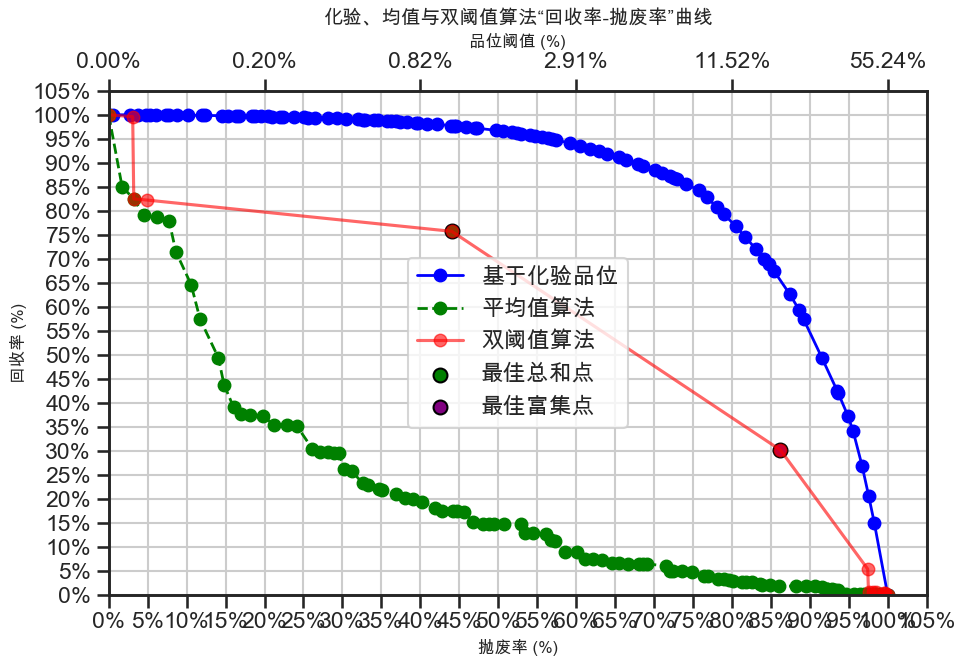

In [140]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# 绘制曲线
baseline_model.plot_curves(
    scrap_rates_ideal=scrap_rates_ideal,
    recovery_rates_ideal=recovery_rates_ideal,
    grade_thresholds_ideal=grade_thresholds_ideal,
    scrap_rates_baseline=scrap_rates_baseline,
    recovery_rates_baseline=recovery_rates_baseline,
    pareto_front=pareto_front,
    best_sum_point=best_sum_point,
    best_enrichment_point=best_enrichment_point,
    best_constraint_point=best_constraint_point)

### 普通R值+阈值法

In [63]:
R_0219_mean.max()

0.8779786978830066

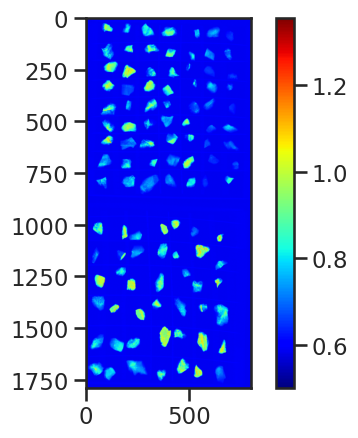

[[5, 19.8, 97.0], [6, 26.5, 95.1]]
0.7000000000000001 0.7100000000000001


{'抛废率': '0.265',
 '回收率': '0.951',
 '铅富集比': '1.449',
 '锌富集比': '1.406',
 '铅平均品位（保留）': '3.407',
 '锌平均品位（保留）': '4.782',
 '铅平均品位（抛废）': '0.352',
 '锌平均品位（抛废）': '0.830',
 '铅平均品位': '2.352',
 '锌平均品位': '3.401'}

In [ ]:

consts = [5, 20]
results_0219 = R_from_path(*pre_0219[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)
plt.imshow(results_0219[1], cmap = 'jet')   
plt.colorbar()
plt.show()
R_0219_mean = np.array([results_0219[0][i].mean() for i in range(len(results_0219[0]))])
minr = R_0219_mean.min(); maxr = R_0219_mean.max()
# rrange = np.arange(minr, maxr, 0.001)
rrange = np.arange(0.65, 0.9, 0.01)
test_r = get_and_plot_rates(R_0219_mean[:99], rrange, true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accuracy_weight=weight[0:99], plot=False)

closest_points = find_closest_point(test_r[2], test_r[3])
print(closest_points)
print(rrange[closest_points[0][0]], rrange[closest_points[1][0]]) # 找出满足对应抛费率和回收率的R值
calculate_rates(R_0219_mean[0:99] > rrange[closest_points[1][0]], true_0219[0:99, :])


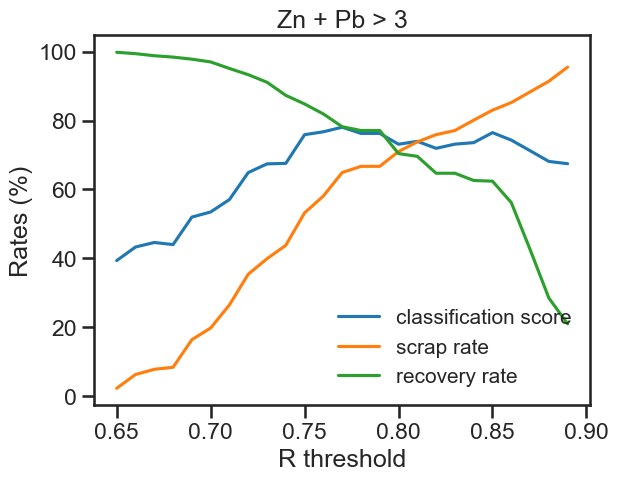

[[19.8, 97.0], [26.5, 95.1]]


In [ ]:
test_r = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9, 0.01], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accuracy_weight=weight[0:99], plot=False)
print(find_closest_point(test_r[2], test_r[3]))

In [148]:
final_0219_by_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=weight[0:99])

final_0219_no_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=None)

final_0219_by_zn_pb_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=zn_pb_0219[0:99])

final_0219_by_zn_pb_fe_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_fe_0219[0:99]> 10, title = 'Zn + Pb + Fe> 10', accurace_weight=zn_pb_fe_0219[0:99], plot=False)

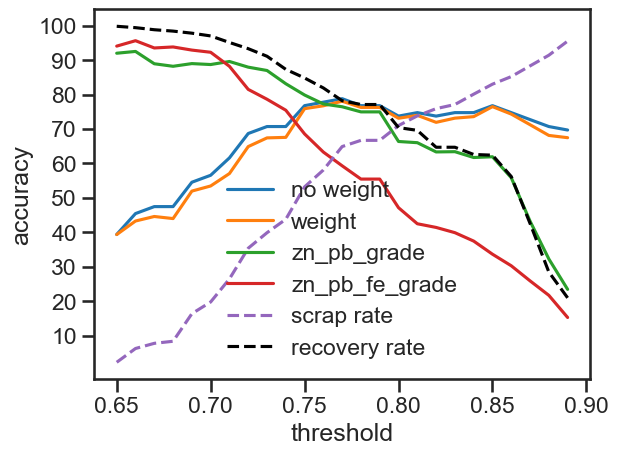

In [87]:
plt.plot(final_0219_no_weight[0], final_0219_no_weight[1], label = 'no weight')
plt.plot(final_0219_by_weight[0], final_0219_by_weight[1], label = 'weight')
plt.plot(final_0219_by_zn_pb_grade[0], final_0219_by_zn_pb_grade[1], label = 'zn_pb_grade')
plt.plot(final_0219_by_zn_pb_fe_grade[0], final_0219_by_zn_pb_fe_grade[1], label = 'zn_pb_fe_grade')

plt.plot(final_0219_no_weight[0],final_0219_no_weight[2], '--', label = 'scrap rate')
plt.plot(final_0219_no_weight[0],final_0219_no_weight[3], 'k--', label = 'recovery rate')

plt.yticks(np.arange(10, 101, 10))
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend(frameon = False)
plt.show()

In [24]:
results_dual_thresh = np.load('results_dual_thresh.npy')

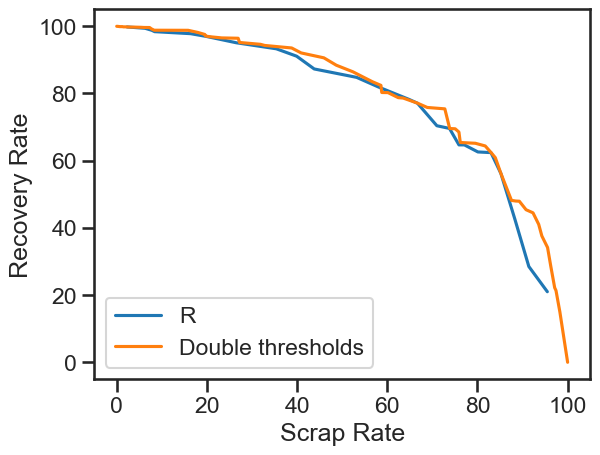

In [32]:

plt.plot(final_0219[2], final_0219[3], label = 'R')
plt.plot(results_dual_thresh[0]*100, results_dual_thresh[1]*100, label = 'Double thresholds')
plt.xlabel('Scrap Rate')
plt.ylabel('Recovery Rate')
plt.legend()
plt.show()

#### test on 0217 data

In [869]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contour
results_0217 = R_from_path(path_0217, [None, None, None, None], I0_low, I0_high, 
                            input = 'pixels', method = 'a', max_len = 7, length=35,
                            direction = 'lrub', s_i = 0, save_rock_image=False)

In [874]:
R_0217_mean = np.array([results_0217[0][i].mean() for i in range(42)])
true_0217 = [1]*21 + [0]*21

In [929]:
for r in np.arange(0.7, 0.85, 0.01):
    print('%.2f'%r, '%.2f'%accuracy_score(true_0217, R_0217_mean > r, normalize=True))

0.70 0.86
0.71 0.88
0.72 0.93
0.73 0.95
0.74 0.95
0.75 1.00
0.76 1.00
0.77 0.95
0.78 0.90
0.79 0.90
0.80 0.88
0.81 0.88
0.82 0.88
0.83 0.83
0.84 0.81
0.85 0.79


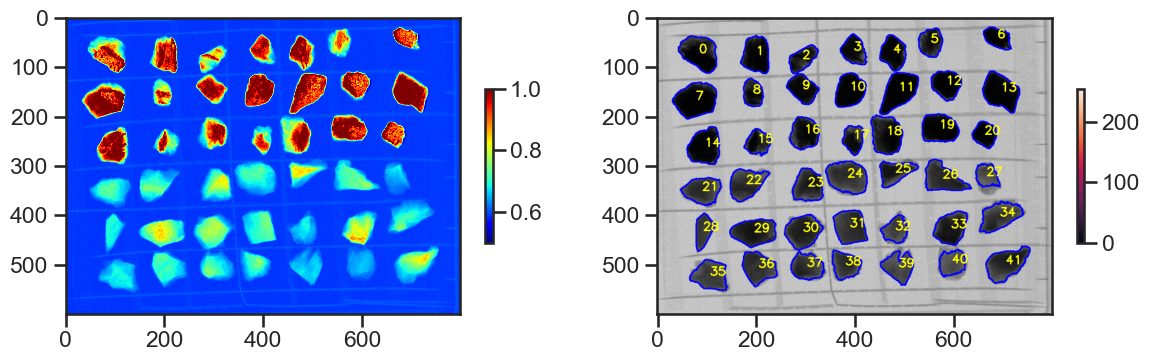

In [927]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
im = axes[0].imshow(results_0217[1][50:650, 400:1200], vmin = 0.5, vmax = 1, cmap = 'jet')
fig.colorbar(im, ax=axes[0], shrink=0.5)
im6 = axes[1].imshow(results_0217[-3][50:650, 400:1200])
fig.colorbar(im6, ax = axes[1], shrink=0.5)

plt.show()

### fitting method

- I_high - I_low
- R - I_low

In [931]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contours
len(results_0217[-2][1])

42

In [1023]:
I_low_g = [rock.mean() for rock in results_0217[-2][0][0:21]]
I_high_g = [rock.mean() for rock in results_0217[-2][1][0:21]]
R_g = R_0217_mean[0:21]
R_b = R_0217_mean[21:]
I_low_b = [rock.mean() for rock in results_0217[-2][0][21:]]
I_high_b = [rock.mean() for rock in results_0217[-2][1][21:]]

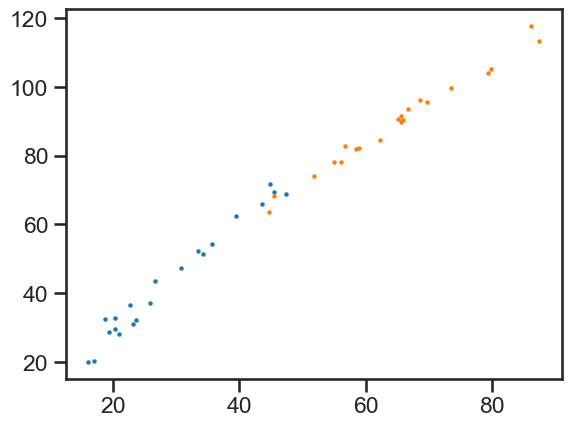

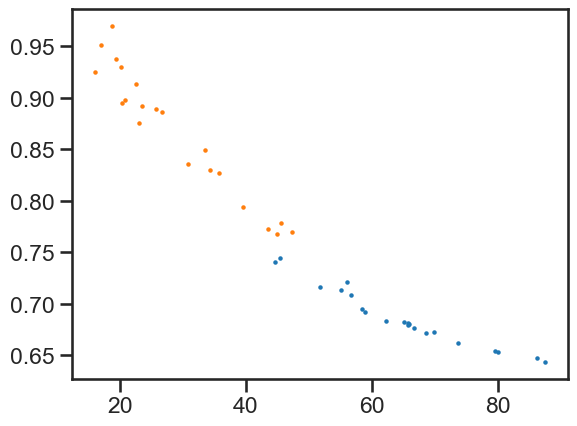

In [1024]:
plt.scatter(I_low_g, I_high_g, s=3)
plt.scatter(I_low_b, I_high_b, s=3)
plt.show()
plt.scatter(I_low_b, R_b, s=3)
plt.scatter(I_low_g, R_g, s=3)
plt.show()

In [1070]:
def plot_dis(low_mask, high_mask):
    I_low_g = [rock.mean() for rock, m in zip(results_0219[-1][0], high_mask) if m]
    I_high_g = [rock.mean() for rock, m in zip(results_0219[-1][1], high_mask) if m]

    R_g = R_0219_mean[0:99][high_mask]
    R_b = R_0219_mean[0:99][low_mask]
    I_low_b = [rock.mean() for rock, m in zip(results_0219[-1][0], low_mask) if m]
    I_high_b = [rock.mean() for rock, m in zip(results_0219[-1][1], low_mask) if m]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(I_low_g, I_high_g, s=3, label='ore')
    axes[0].scatter(I_low_b, I_high_b, s=3, label='waste')
    axes[0].set_xlabel('I_low')
    axes[0].set_ylabel('I_high')

    x1 = np.linspace(axes[0].get_xlim()[0], axes[0].get_xlim()[1], 100)
    axes[0].plot(x1, x1, color='red', linestyle='--', label='y = x', alpha = 0.6)

    axes[0].legend(frameon=False)

    axes[1].scatter(I_low_g, R_g, s=3, label='ore')
    axes[1].scatter(I_low_b, R_b, s=3, label='waste')
    axes[1].set_xlabel('I_low')
    axes[1].set_ylabel('R')
    axes[1].legend(frameon=False)

    plt.show()

    return {'I_low_g':I_low_g, 
            'I_high_g':I_high_g, 
            'R_g':R_g, 
            'I_low_b':I_low_b, 
            'I_high_b':I_high_b, 
            'R_b':R_b}

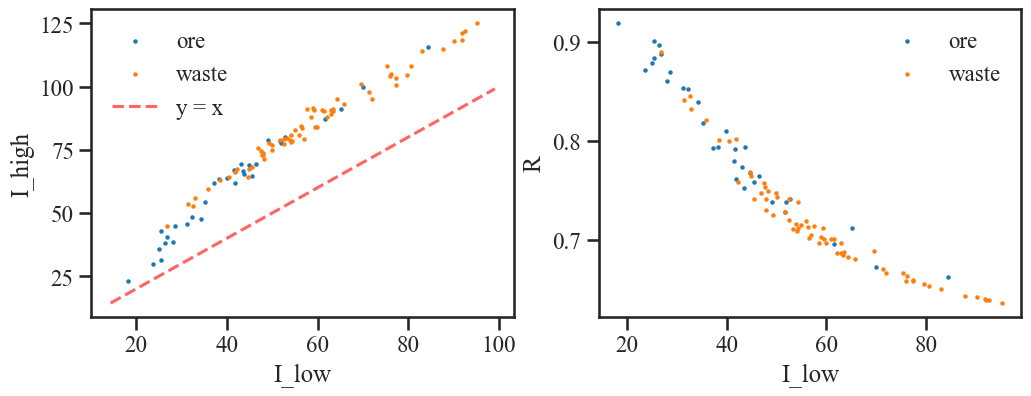

In [1061]:
high_mask = zn_pb_0219[0:99] > 3
plot_dis(~high_mask, high_mask)

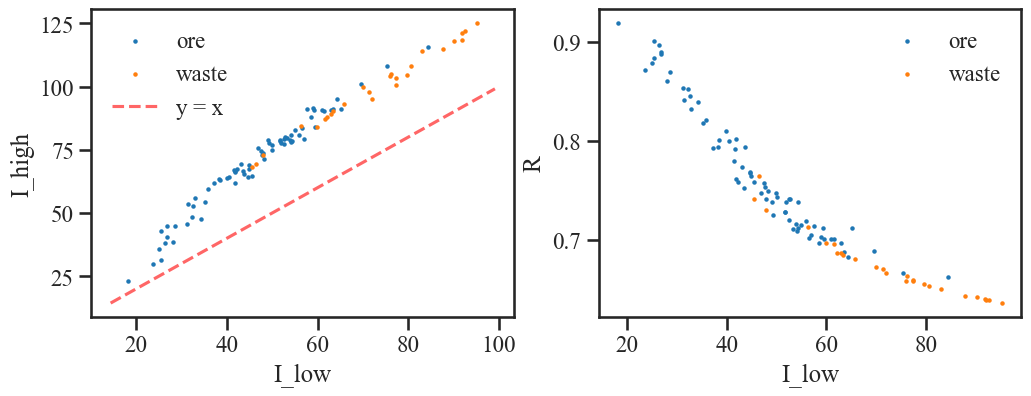

In [1071]:
high_mask = zn_pb_fe_0219[0:99] > 10
dis_fe = plot_dis(~high_mask, high_mask)

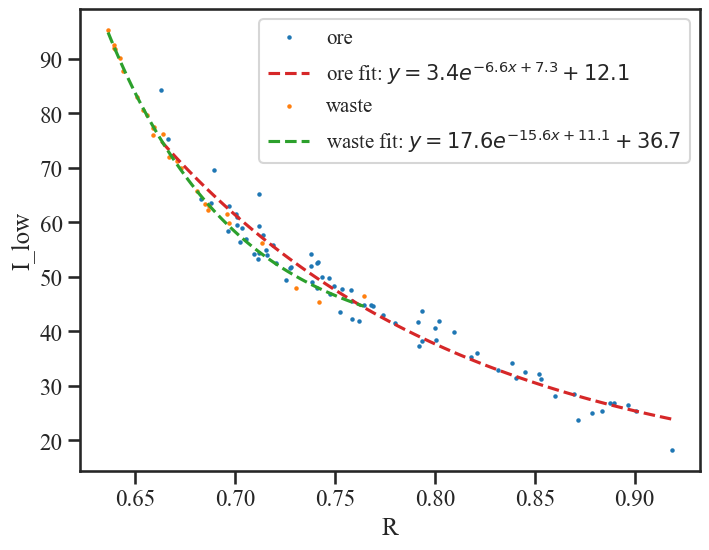

In [1150]:
def exponential_func(x, a, b, c, d):
    return a * np.exp(b * x + c) + d

I_low_g = dis_fe['I_low_g'] 
R_g = dis_fe['R_g']

I_low_b = dis_fe['I_low_b'] 
R_b = dis_fe['R_b']

# 对 ore 数据进行指数拟合
if len(I_low_g) > 0 and len(R_g) > 0:
    popt_ore, pcov  = curve_fit(exponential_func, R_g, I_low_g)
    x_ore = np.linspace(min(R_g), max(R_g), 100)
    y_ore = exponential_func(x_ore, *popt_ore)

# 对 waste 数据进行指数拟合
if len(I_low_b) > 0 and len(R_b) > 0:
    popt_waste, _ = curve_fit(exponential_func, R_b, I_low_b)
    x_waste = np.linspace(min(R_b), max(R_b), 100)
    y_waste = exponential_func(x_waste, *popt_waste)

plt.figure(figsize=(8, 6))
plt.scatter(R_g, I_low_g, s=3, label='ore')

formula_ore = f'$y = {popt_ore[0]:.1f}e^{{{popt_ore[1]:.1f}x + {popt_ore[2]:.1f}}} + {popt_ore[3]:.1f}$'

plt.plot(x_ore, y_ore, '--', color = cycle[3], label=f'ore fit: {formula_ore}')
plt.scatter(R_b, I_low_b, s=3, label='waste')
formula_waste = f'$y = {popt_waste[0]:.1f}e^{{{popt_waste[1]:.1f}x + {popt_waste[2]:.1f}}} + {popt_waste[3]:.1f}$'
plt.plot(x_waste, y_waste, '--', color = cycle[2], label=f'waste fit: {formula_waste}')
plt.legend(fontsize = 15)

plt.ylabel('I_low')
plt.xlabel('R')
plt.show()